In [217]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [218]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

In [219]:
train_file = "/Users/Jeff/Desktop/Digit Recognizer/train.csv"
test_file = "/Users/Jeff/Desktop/Digit Recognizer/test.csv"
output_file = "/Users/Jeff/Desktop/Digit Recognizer/submission24.csv"

Split the data into a training set and a validation set,

In [220]:
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
x_train, x_val, y_train, y_val = train_test_split(
    raw_data[:,1:], raw_data[:,0], test_size=0.1)

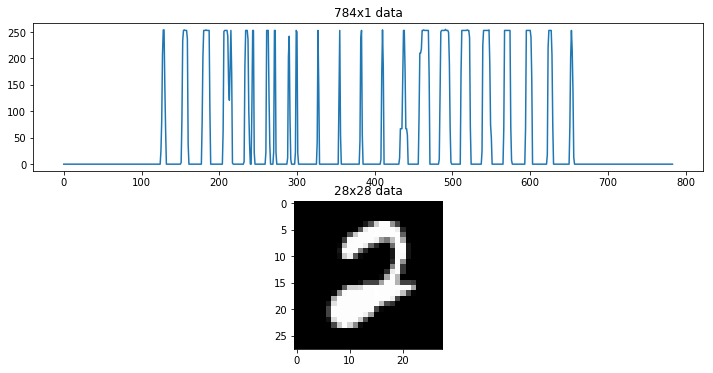

In [221]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(x_train[0])
ax[0].set_title('784x1 data')
ax[1].imshow(x_train[0].reshape(28,28), cmap='gray')
ax[1].set_title('28x28 data')

In [222]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

Make the net converge faster

In [223]:
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.

Convert these to one-hot encoding

In [224]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
#example:
print(y_train[0])

[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


Train the model

In [225]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu',
                 input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Using the augmentation to do generalization

In [226]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

Using the logloss which is called ''categorical_crossentropy" in Keras

In [227]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

To speed things up, reduce the learning rate by 10% every epoch

In [228]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [ ]:
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=16),
                           steps_per_epoch=500,
                           epochs=100, #Increase this when not on Kaggle kernel
                           verbose=2,  #1 for ETA, 0 for silent
                           validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           callbacks=[annealer])

Epoch 1/100
68s - loss: 1.6319 - acc: 0.4520 - val_loss: 0.5628 - val_acc: 0.8050
Epoch 2/100
78s - loss: 0.7952 - acc: 0.7405 - val_loss: 0.1457 - val_acc: 0.9575
Epoch 3/100
100s - loss: 0.5667 - acc: 0.8277 - val_loss: 0.0879 - val_acc: 0.9725
Epoch 4/100
82s - loss: 0.4391 - acc: 0.8674 - val_loss: 0.1098 - val_acc: 0.9650
Epoch 5/100
80s - loss: 0.3939 - acc: 0.8825 - val_loss: 0.0902 - val_acc: 0.9650
Epoch 6/100
84s - loss: 0.3714 - acc: 0.8952 - val_loss: 0.0552 - val_acc: 0.9800
Epoch 7/100
84s - loss: 0.3165 - acc: 0.9066 - val_loss: 0.0903 - val_acc: 0.9725
Epoch 8/100
84s - loss: 0.3025 - acc: 0.9121 - val_loss: 0.0779 - val_acc: 0.9775
Epoch 9/100
75s - loss: 0.2880 - acc: 0.9167 - val_loss: 0.0780 - val_acc: 0.9725
Epoch 10/100
71s - loss: 0.2619 - acc: 0.9251 - val_loss: 0.0799 - val_acc: 0.9675
Epoch 11/100
74s - loss: 0.2357 - acc: 0.9309 - val_loss: 0.0485 - val_acc: 0.9775
Epoch 12/100
71s - loss: 0.2323 - acc: 0.9330 - val_loss: 0.0612 - val_acc: 0.9825
Epoch 13/100

Evaluate

In [206]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0234, final accuracy: 0.9943


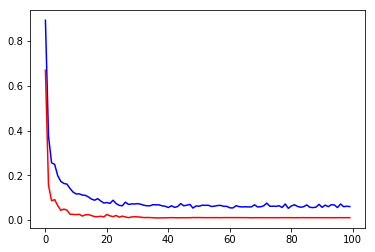

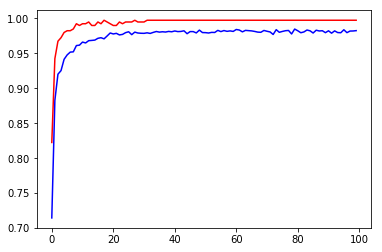

In [207]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [208]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[417   0   0   0   0   0   0   0   0   0]
 [  0 486   0   0   0   0   0   2   0   0]
 [  0   0 415   0   0   0   0   3   0   0]
 [  0   0   0 418   0   1   0   0   0   0]
 [  0   0   0   0 407   0   0   0   0   3]
 [  0   0   0   0   0 378   1   0   0   0]
 [  1   0   0   0   0   0 407   0   0   0]
 [  0   0   2   0   0   0   0 436   0   0]
 [  0   0   0   0   1   0   1   0 434   4]
 [  0   0   0   0   2   1   0   2   0 378]]


Submit

In [209]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1)/255.

In [210]:
y_hat = model.predict(x_test, batch_size=64)

Select the class with highest probability

In [211]:
y_pred = np.argmax(y_hat,axis=1)

In [212]:
with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))